## POE5 Chapter 8: Heteroskedasticity

### Done.

### 7.1 The Nature of Het..

#### POE5 Example 8.1 Het in the Fod Expenditure Model


In [1]:
%config InlineBackend.figure_format = "retina"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  ; sns.set_style('whitegrid',  {"grid.color": '.95'})
import statsmodels.formula.api as smf
import statsmodels.regression.linear_model  as lm
from scipy import stats
from pystout import pystout

In [2]:
poe5csv = 'http://principlesofeconometrics.com/poe5/data/csv/'
food = pd.read_csv(poe5csv+'food.csv')
res = smf.ols('food_exp ~ income',data=food).fit()

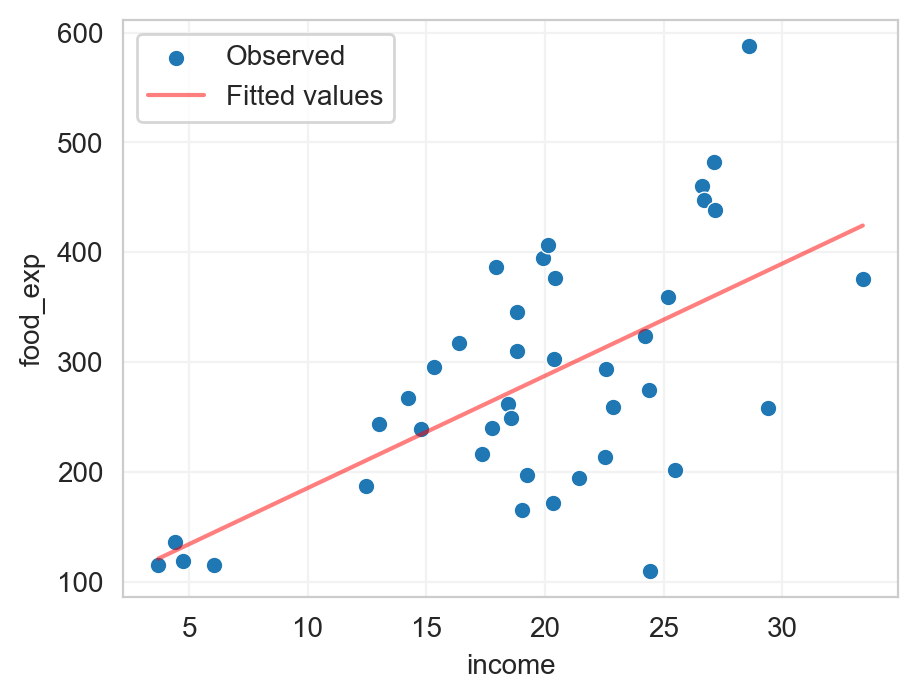

In [3]:
sns.scatterplot(x=food.income,y=food.food_exp,label="Observed")
plt.plot(food.income,res.predict(),'r-',alpha=0.5,label="Fitted values")
plt.legend();

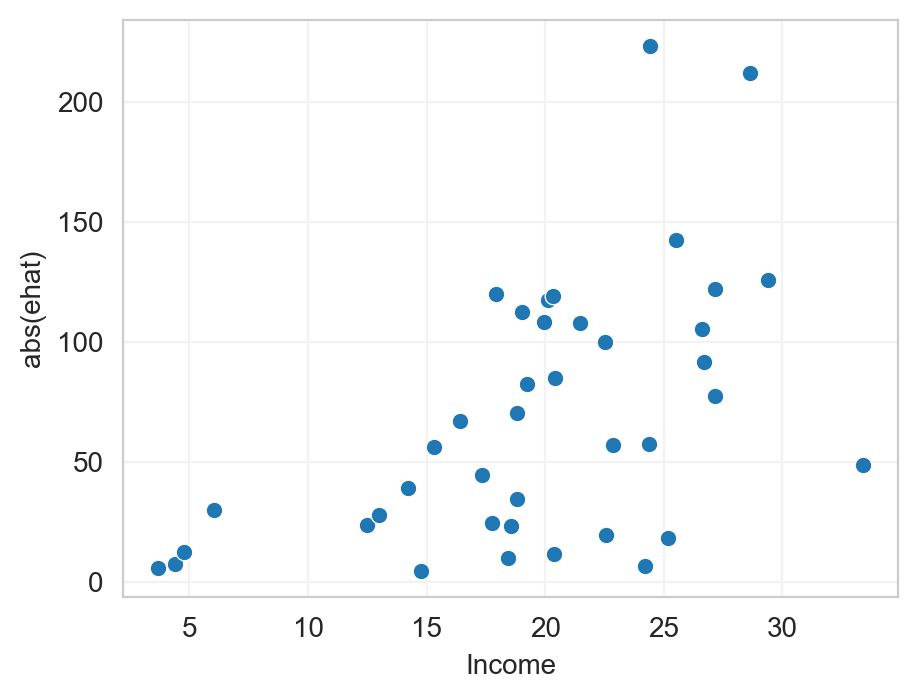

In [4]:
ax = sns.scatterplot(x=food.income,y=abs(res.resid))
ax.set_xlabel("Income")
ax.set_ylabel("abs(ehat)");

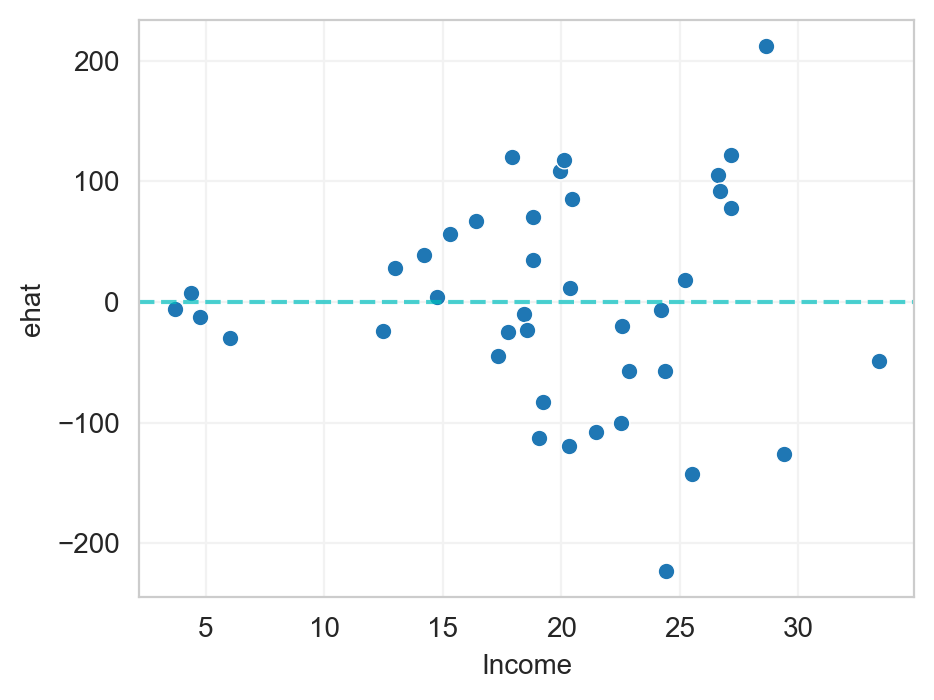

In [5]:
ax = sns.scatterplot(x=food.income,y=res.resid)
ax.set_xlabel("Income")
ax.set_ylabel("ehat")
ax.axhline(c='c',ls='--',alpha=0.7);  # Plot horizontal line at y=0

#### POE5 Example 8.2 Robust Standard Errors in the Food Expenditure Model

In [6]:
mod1 = smf.ols('food_exp ~ income',data=food).fit()
temp = mod1.get_robustcov_results(cov_type='HC1')
mod2 = lm.RegressionResultsWrapper(temp)

pystout(models=[mod1,mod2],
        file='Table8.2.tex',
        digits=4,
        stars={.05:'*',0.01:"**",0.001:'***'},
        addnotes=['Standard errors in parentheses',
                  '* $p<0.05$, ** $p<0.01$, *** $p<0.001$'])

# Alternate print method not requiring pystout.  Uncomment following 2 lines
#from statsmodels.iolib.summary2 import summary_col
#print(summary_col([mod1,mod2],stars=True,model_names=('mod1','mod2')))

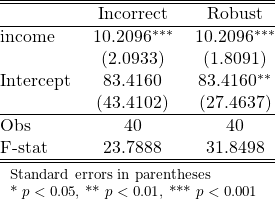

In [7]:
ci1 = mod1.conf_int()
print(f"Incorrect estimate [and 95% CI]:\n"
      f"   Income    = {mod1.params.income:.4f}  "
      f"[{ci1[0].income:.4f}, {ci1[1].income:.4f}]\n"
      f"   Intercept = {mod1.params.Intercept:.4f}  "
      f"[{ci1[0].Intercept:.4f}, {ci1[1].Intercept:.4f}]\n")

ci2 = mod2.conf_int()
print(f"Robust estimate [and 95% CI]:\n"
      f"   Income    = {mod2.params.income:.4f}  "
      f"[{ci2[0].income:.4f}, {ci2[1].income:.4f}]\n"
      f"   Intercept = {mod2.params.Intercept:.4f}  "
      f"[{ci2[0].Intercept:.4f}, {ci2[1].Intercept:.4f}]")

Incorrect estimate [and 95% CI]:
   Income    = 10.2096  [5.9721, 14.4472]
   Intercept = 83.4160  [-4.4633, 171.2953]

Robust estimate [and 95% CI]:
   Income    = 10.2096  [6.5474, 13.8719]
   Intercept = 83.4160  [27.8186, 139.0135]


#### POE5 Example 8.3 Applying GLS/WLS to the Food Expenditure Data

In [8]:
food['ystar'] = food.food_exp/np.sqrt(food.income)
food['x1star'] = 1/np.sqrt(food.income)
food['x2star'] = food.income/np.sqrt(food.income)

# -1 in formula is used to prevent inserting the intercept variable.
mod_star = smf.ols('ystar ~ x1star + x2star - 1',data=food).fit()

print(mod_star.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1star        78.6841     23.789      3.308      0.002      30.526     126.842
x2star        10.4510      1.386      7.541      0.000       7.645      13.257


In [9]:
mod3 = smf.wls('food_exp ~ income',data=food,weights=1/food.income).fit()

print(mod3.summary(slim=True))

                            WLS Regression Results                            
Dep. Variable:               food_exp   R-squared:                       0.599
Model:                            WLS   Adj. R-squared:                  0.589
No. Observations:                  40   F-statistic:                     56.87
Covariance Type:            nonrobust   Prob (F-statistic):           4.61e-09
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     78.6841     23.789      3.308      0.002      30.526     126.842
income        10.4510      1.386      7.541      0.000       7.645      13.257

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


In [10]:
food['estar'] = mod_star.resid
food['ehat_gls'] = mod3.resid
food['ehat2'] = mod3.resid / np.sqrt(food.income)
print(food[['estar','ehat_gls','ehat2']].head())

       estar   ehat_gls      ehat2
0  -1.055893  -2.028304  -1.055893
1   5.448555  11.415990   5.448555
2  -4.123231  -8.986373  -4.123231
3 -10.890862 -26.743665 -10.890862
4  -6.218173 -21.958163  -6.218173


In [11]:
mod4 = mod3.get_robustcov_results(cov_type='HC1')
mod4 = lm.RegressionResultsWrapper(mod4)

pystout(models=[mod2,mod3,mod4],
        file='Table8.3.tex',
        digits=4,
        stars={.05:'*',0.01:"**",0.001:'***'},
        endog_names=['OLS Robust','GLS','GLS Robust'],
        addnotes=['Standard errors in parentheses',
                  '* $p<0.05$, ** $p<0.01$, *** $p<0.001$'],
        modstat={'nobs':'Obs','fvalue':'F-stat'})

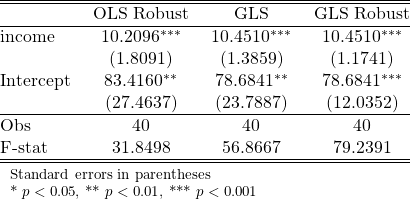

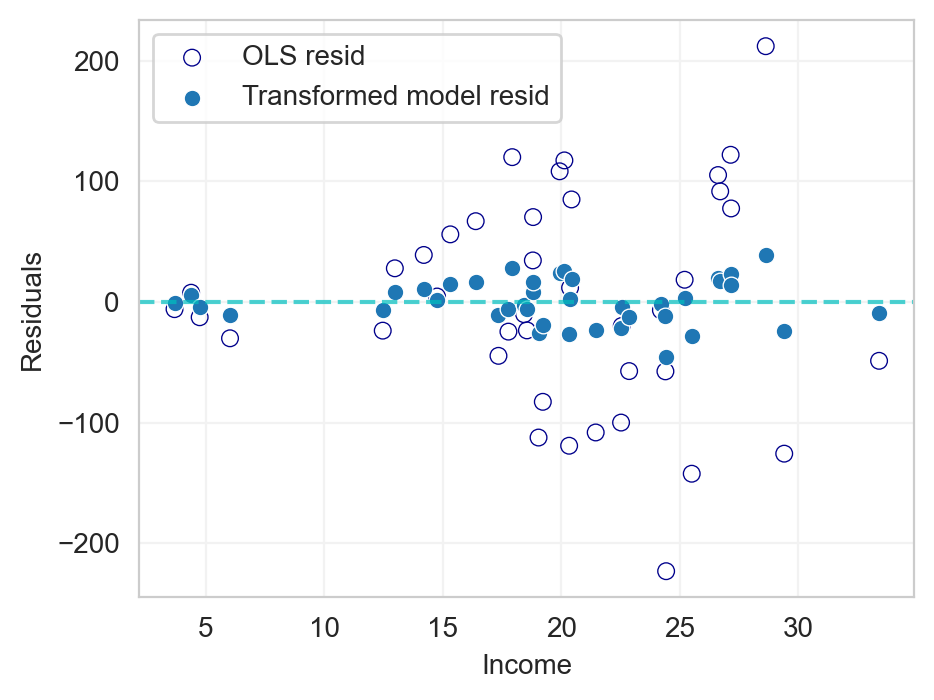

In [12]:
ax = sns.scatterplot(x=food.income,y=mod1.resid,facecolors='none',
                     edgecolor='darkblue',label="OLS resid")
sns.scatterplot(x=food.income,y=food.estar,
                label="Transformed model resid",ax=ax)
ax.set_xlabel("Income")
ax.set_ylabel("Residuals")
plt.legend()
ax.axhline(c='c',ls='--',alpha=0.7);

#### POE5 Example 8.4 Multiplicative Het in the Food Expenditure Model

In [13]:
food['z2'] = np.log(food.income)
food['lehat_sq'] = np.log(mod1.resid**2)

res4a = smf.ols('lehat_sq ~ z2',data=food).fit()

print(res4a.summary(slim=True,title='OLS Regression Results'))

                            OLS Regression Results                            
Dep. Variable:               lehat_sq   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.310
No. Observations:                  40   F-statistic:                     18.51
Covariance Type:            nonrobust   Prob (F-statistic):           0.000114
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9378      1.583      0.592      0.557      -2.267       4.143
z2             2.3292      0.541      4.303      0.000       1.233       3.425

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


In [14]:
food['sighat'] = res4a.predict()
food['wt'] = np.exp(food.sighat)

res4b = smf.wls('food_exp ~ income',data=food,weights=1/food.wt).fit()

print(res4b.summary(slim=True,title='WLS Regression Results'))

                            WLS Regression Results                            
Dep. Variable:               food_exp   R-squared:                       0.759
Model:                            WLS   Adj. R-squared:                  0.753
No. Observations:                  40   F-statistic:                     119.8
Covariance Type:            nonrobust   Prob (F-statistic):           2.62e-13
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     76.0538      9.713      7.830      0.000      56.390      95.718
income        10.6335      0.972     10.945      0.000       8.667      12.600

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


#### POE5 Example 8.5 A het partition

In [15]:
cps5s = pd.read_csv(poe5csv+'cps5_small.csv')
cps5s = cps5s[cps5s.midwest==1]  # Keep only midwest region rows

vars = ['wage','educ','exper']
print(cps5s[cps5s.metro==1][vars].describe(percentiles=[]).transpose())

       count       mean        std   min    50%    max
wage   213.0  24.247042  14.001746  6.17  21.63  80.77
educ   213.0  14.248826   2.770985  3.00  14.00  21.00
exper  213.0  23.154930  13.166547  0.00  23.00  52.00


In [16]:
print(cps5s[cps5s.metro==0][vars].describe(percentiles=[]).transpose())

       count       mean        std   min    50%    max
wage    84.0  18.862143   8.520368  5.78  17.84  53.84
educ    84.0  13.988095   2.262816  8.00  13.00  20.00
exper   84.0  24.297619  14.316373  1.00  25.00  56.00


In [17]:
formula = 'wage ~ educ + exper + metro'
res5a = smf.ols(formula=formula,data=cps5s).fit()
res5a = lm.RegressionResultsWrapper(res5a.get_robustcov_results(cov_type='HC1'))

print(res5a.summary(slim=True,title="Robust OLS"))

                                  Robust OLS                                  
Dep. Variable:                   wage   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.267
No. Observations:                 297   F-statistic:                     31.56
Covariance Type:                  HC1   Prob (F-statistic):           1.04e-17
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.4500      4.023     -4.586      0.000     -26.368     -10.532
educ           2.3391      0.261      8.975      0.000       1.826       2.852
exper          0.1890      0.048      3.951      0.000       0.095       0.283
metro          4.9910      1.159      4.308      0.000       2.711       7.271

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)


In [18]:
cps5s['lehat2'] = np.log(res5a.resid**2)

res5b = smf.ols('lehat2 ~ metro',data=cps5s).fit()

print(res5b.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                 lehat2   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.019
No. Observations:                 297   F-statistic:                     6.735
Covariance Type:            nonrobust   Prob (F-statistic):            0.00992
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8953      0.229     12.667      0.000       2.445       3.345
metro          0.7005      0.270      2.595      0.010       0.169       1.232

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


In [19]:
cps5s['h'] = np.exp(res5b.params.metro*cps5s.metro)

res5c = smf.wls(formula=formula,data=cps5s,weights=1/cps5s.h).fit()

print(res5c.summary(slim=True))

                            WLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.282
Model:                            WLS   Adj. R-squared:                  0.274
No. Observations:                 297   F-statistic:                     38.27
Covariance Type:            nonrobust   Prob (F-statistic):           6.72e-21
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -16.9679      3.788     -4.479      0.000     -24.423      -9.513
educ           2.2580      0.239      9.443      0.000       1.787       2.729
exper          0.1747      0.045      3.907      0.000       0.087       0.263
metro          4.9958      1.214      4.116      0.000       2.607       7.384

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


In [20]:
res5d = res5c.get_robustcov_results(cov_type='HC1')
res5d = lm.RegressionResultsWrapper(res5d)

print(res5d.summary(slim=True))

                            WLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.282
Model:                            WLS   Adj. R-squared:                  0.274
No. Observations:                 297   F-statistic:                     34.50
Covariance Type:                  HC1   Prob (F-statistic):           3.98e-19
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -16.9679      3.739     -4.538      0.000     -24.327      -9.609
educ           2.2580      0.246      9.164      0.000       1.773       2.743
exper          0.1747      0.044      3.928      0.000       0.087       0.262
metro          4.9958      1.159      4.311      0.000       2.715       7.277

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)


#### POE5 Example 8.6 The Goldfeld-Quandt Test with Partitioned Data

In [21]:
cps5s = pd.read_csv(poe5csv+'cps5_small.csv')
cps5s = cps5s[cps5s.midwest==1]    

res_r = smf.ols('wage ~ educ + exper',data=cps5s[cps5s.metro==0]).fit()

print(f"Rural Residual Mean Square = {res_r.mse_resid:.4f}")
#print(res_r.summary(slim=True))  # uncomment to print the summary table

Rural Residual Mean Square = 56.7059


In [22]:
res_m = smf.ols('wage ~ educ + exper',data=cps5s[cps5s.metro==1]).fit()

print(f"Urban Residual Mean Square = {res_m.mse_resid:.4f}")
#print(res_r.summary(slim=True))  # uncomment to print the summary table

Urban Residual Mean Square = 147.6208


In [23]:
GQ = res_m.mse_resid / res_r.mse_resid
F975 = stats.f.ppf(0.975, res_m.df_resid, res_r.df_resid)
F025 = stats.f.ppf(0.025, res_m.df_resid, res_r.df_resid)

print(f"sig2_m = {res_m.mse_resid:8.4f}\n"
      f"sig2_r = {res_r.mse_resid:8.4f}\n"
      f"GQ     = {GQ:8.4f}\n"
      f"F025   = {F025:8.4f}\n"
      f"F975   = {F975:8.4f}")

sig2_m = 147.6208
sig2_r =  56.7059
GQ     =   2.6033
F025   =   0.7049
F975   =   1.4615


#### POE5 Example 8.7 The Goldfeld-Quandt Test in the Food Expenditure Model

Stata manual "Another example of the Goldfeld-Quandt test uses the food expenditure model. In this example the
variance is thought to be an increasing function of income. So, we first sort the data by income
(ascending) and then repeat the Goldfeld-Quandt test. The forty observations are broken into two
equal size partitions. Then the same steps used above are repeated to obtain the result. First load
the food dataset and sort by income"

In [24]:
food = pd.read_csv(poe5csv+'food.csv').sort_values(by=['income'])
res1 = smf.ols('food_exp ~ income',data=food[:20]).fit()  # 1st half
res2 = smf.ols('food_exp ~ income',data=food[20:]).fit()  # 2nd half

GQ = res2.mse_resid / res1.mse_resid
F975 = stats.f.ppf(0.95, res2.df_resid, res1.df_resid)

print(f"sig2_1 = {res1.mse_resid:10.4f}\n"
      f"sig2_2 = {res2.mse_resid:10.4f}\n"
      f"df1    = {res1.df_resid:10}\n"
      f"df2    = {res2.df_resid:10}\n"
      f"F975   = {F975:10.4f}\n"
      f"GQ     = {GQ:10.4f}")

sig2_1 =  3574.7717
sig2_2 = 12921.9266
df1    =       18.0
df2    =       18.0
F975   =     2.2172
GQ     =     3.6148


#### POE5 Example 8.8 Variance Stabilizing Log-Transformation

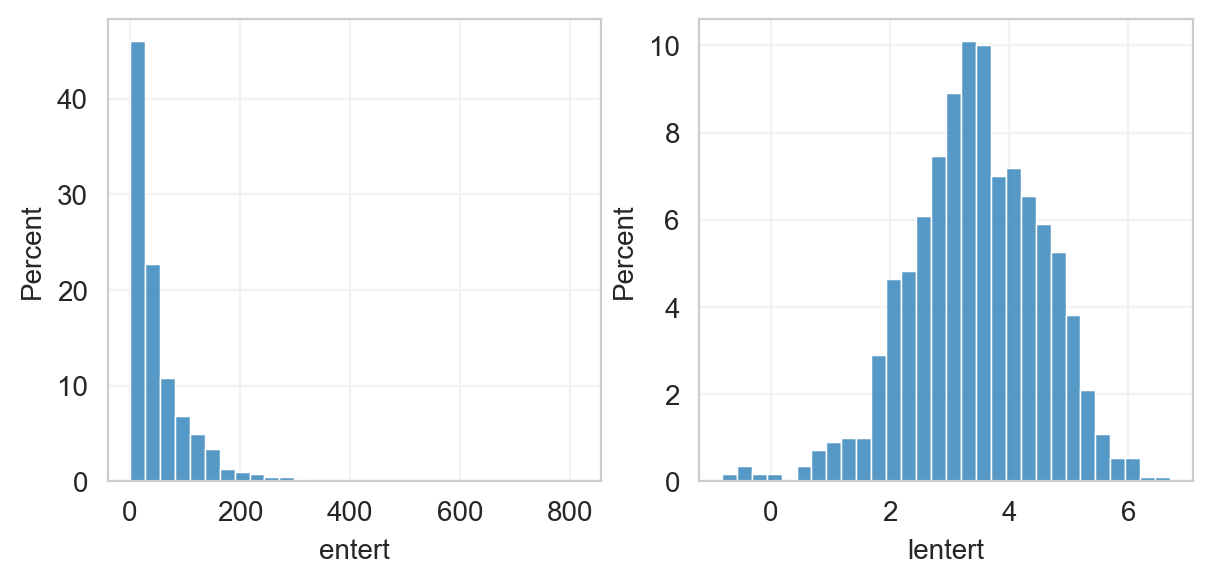

In [25]:
cex5s = pd.read_csv(poe5csv+'cex5_small.csv')
cex5s = cex5s[cex5s.entert>0]
cex5s['lentert'] = np.log(cex5s.entert)

fig, ax = plt.subplots(1,2,figsize=(7,3))
sns.histplot(cex5s.entert,bins=30,stat='percent',ax=ax[0])
sns.histplot(cex5s.lentert,bins=30,stat='percent',ax=ax[1]);

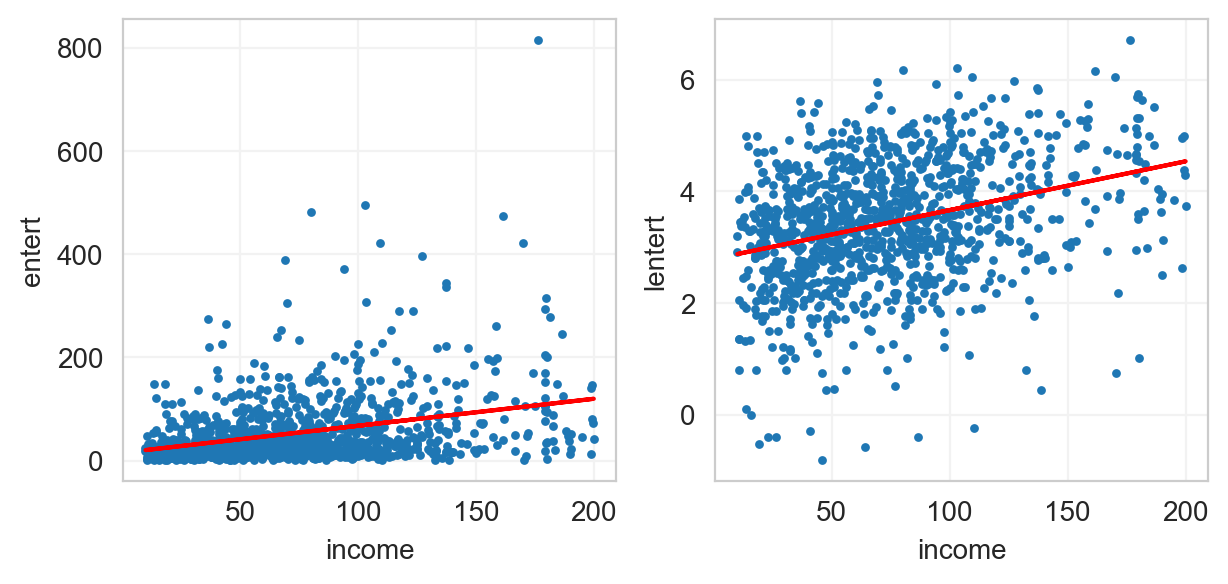

In [26]:
res1  = smf.ols('entert ~ income',data=cex5s).fit()
res1L = smf.ols('lentert ~ income',data=cex5s).fit()

fig, ax = plt.subplots(1,2,figsize=(7,3))
sns.scatterplot(x=cex5s.income,y=cex5s.entert,linewidth=0.0,s=10,ax=ax[0])
ax[0].plot(cex5s.income,res1.predict(),'r-')
sns.scatterplot(x=cex5s.income,y=cex5s.lentert,linewidth=0.0,s=10,ax=ax[1])
ax[1].plot(cex5s.income,res1L.predict(),'r-');

In [27]:
res = smf.ols('entert ~ income + college + advanced',data=cex5s).fit()
resL = smf.ols('lentert ~ income + college + advanced',data=cex5s).fit()

import statsmodels.stats.api as sms

lmval, lmpv, fval, fpval = sms.het_breuschpagan(res.resid,res1.model.exog)
print(f"Linear: Breusch-Pagan test NR2 = {lmval:6.3f}   p-value   = {lmpv:.3f}")
print(f"Linear: F-Statistic            = {fval:6.3f}   F p-value = {fpval:.3f}")

lmval, lmpv, fval, fpval = sms.het_breuschpagan(resL.resid,res1L.model.exog)
print(f"Log   : Breusch-Pagan test NR2 = {lmval:6.3f}   p-value   = {lmpv:.3f}")
print(f"Log   : F-Statistic            = {fval:6.3f}   F p-value = {fpval:.3f}")

chi2_crit = stats.chi2.ppf(0.95, res1.df_model)
print(f"\n0.05 critical value = {chi2_crit:.4f}\n")

Linear: Breusch-Pagan test NR2 = 31.337   p-value   = 0.000
Linear: F-Statistic            = 32.197   F p-value = 0.000
Log   : Breusch-Pagan test NR2 =  0.355   p-value   = 0.551
Log   : F-Statistic            =  0.355   F p-value = 0.552

0.05 critical value = 3.8415



In [28]:
lmval, lmpv, fval, fpval = sms.het_white(res.resid,res.model.exog)
print(f"Linear: White test statistic = {lmval:6.3f}   p-value   = {lmpv:.3f}")
print(f"Linear: F-Statistic          = {fval:6.3f}   F p-value = {fpval:.3f}")

lmval, lmpv, fval, fpval = sms.het_white(resL.resid,res1L.model.exog)
print(f"Log   : White test statistic = {lmval:6.3f}   p-value   = {lmpv:.3f}")
print(f"Log   : F-Statistic          = {fval:6.3f}   F p-value = {fpval:.3f}")

Linear: White test statistic = 51.656   p-value   = 0.000
Linear: F-Statistic          =  8.976   F p-value = 0.000
Log   : White test statistic =  1.534   p-value   = 0.464
Log   : F-Statistic          =  0.766   F p-value = 0.465


#### POE5 Example 8.9 The Marketing Example Revisited

In [29]:
coke = pd.read_csv(poe5csv+'coke.csv')

print(coke.describe(percentiles=[]).transpose())

             count      mean       std       min   50%       max
coke        1140.0  0.447368  0.497440  0.000000  0.00  1.000000
pr_pepsi    1140.0  1.202719  0.300726  0.680000  1.19  1.790000
pr_coke     1140.0  1.190088  0.299916  0.680000  1.19  1.790000
disp_pepsi  1140.0  0.364035  0.481370  0.000000  0.00  1.000000
disp_coke   1140.0  0.378947  0.485338  0.000000  0.00  1.000000
pratio      1140.0  1.027249  0.286608  0.497207  1.00  2.324675


In [30]:
formula = 'coke ~ pratio + disp_coke + disp_pepsi'
res = smf.ols(formula=formula,data=coke).fit()

lmval, lmpv, fval, fpval = sms.het_white(res.resid,res.model.exog)
print(f"White test statistic = {lmval:6.3f}   p-value   = {lmpv:.3f}")

White test statistic = 25.817   p-value   = 0.001


In [31]:
res_rob = lm.RegressionResultsWrapper(res.get_robustcov_results(cov_type='HC1'))

coke['p'] = res_rob.predict()
coke['vari'] = coke.p*(1-coke.p)

print(coke[['p','vari']].describe(percentiles=[]).transpose())

       count      mean       std       min       50%       max
p     1140.0  0.447368  0.172361 -0.207321  0.459632  0.768078
vari  1140.0  0.217548  0.052991 -0.250303  0.240172  0.249940


In [32]:
coke_omit = coke[coke.p>0].copy()
res_omit = smf.wls(formula=formula,data=coke_omit,weights=1/coke_omit.vari).fit()

In [33]:
coke['p'] = np.where(coke['p'] < 0, 0.01, coke['p'])
coke['vari'] = coke.p*(1-coke.p)

res_trunc = smf.wls(formula=formula,data=coke,weights=1/coke.vari).fit()

In [34]:
pystout(models=[res,res_rob,res_omit,res_trunc],
        file='Table8.9.tex',
        digits=4,
        stars={.05:'*',0.01:"**",0.001:'***'},
        endog_names=['OLS','Robust','Omit','Trunc'],
        addnotes=['Standard errors in parentheses',
                  '* $p<0.05$, ** $p<0.01$, *** $p<0.001$'],
        modstat={'nobs':'Obs','fvalue':'F-stat'})

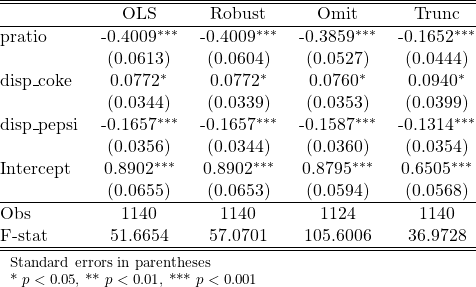

#### POE Example 8.10 Alternative Robust Standard Errors in the Food Expenditure Model

In [35]:
food = pd.read_csv(poe5csv+'food.csv')

m0 = smf.ols('food_exp ~ income',data=food).fit()
m1 = lm.RegressionResultsWrapper(m0.get_robustcov_results(cov_type='HC1'))
m2 = lm.RegressionResultsWrapper(m0.get_robustcov_results(cov_type='HC2'))
m3 = lm.RegressionResultsWrapper(m0.get_robustcov_results(cov_type='HC3'))

pystout(models=[m0,m1,m2,m3],
        file='Table8.10.tex',
        digits=4,
        stars={.05:'*',0.01:"**",0.001:'***'},
        endog_names=['OLS (Incorrect)','HC1','HC2','HC3'],
        addnotes=['Standard errors in parentheses',
                  '* $p<0.05$, ** $p<0.01$, *** $p<0.001$'],
        modstat={'nobs':'Obs','fvalue':'F-stat'})

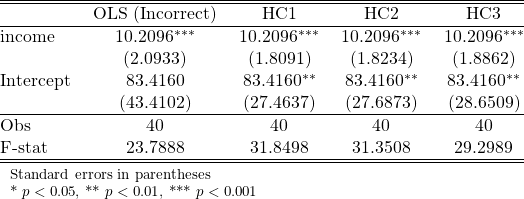


#### POE Appendix 8E Monte Carlo Evidence: OLS, GLS, and FGLS

In [36]:
nobs = [100, 100, 100, 5000, 5000]
numsims = 1000
alpha2 = [0, 0.3, 0.5, 0.5, 0.5]
hbar = [2.718818, 6.938608, 13.8982, 14.25737, 6.025252]
flag = [0,0,0,0,1]

np.random.seed(42)  # for reproducable results

def hz(x,alpha,hbar,flag):
    x = np.asarray(x)
    if flag==0:
        return 3 * np.exp(1 + alpha * x)/hbar    # columns 1-4
    else:
        return 3 * (1 + 10*np.random.random(len(x)))/hbar  # column 5
    
def printit(n,alpha,mcres):
    print(f" 1: N              = {n:3}\n"
      f" 2: alpha2         = {a2:3.1f}\n"
      f" 3: mean b2        = {mcres.b2.mean():6.4f}\n"
      f" 4: sd(b2)         = {mcres.b2.std():6.4f}\n"
      f" 5: mean se(b2)    = {mcres.b2se.mean():6.4f}\n"
      f" 6: mean b2robse   = {mcres.b2robse.mean():6.4f}\n"
      f" 7: rej(NR^2)      = {mcres.rejnr2.mean():6.4f}\n"
      f" 8: mean b2f       = {mcres.b2f.mean():6.4f}\n"
      f" 9: sd(b2f)        = {mcres.b2f.std():6.4f}\n"
      f"10: sd(b2f)/sd(b2) = {mcres.b2f.std()/mcres.b2.std():6.4f}\n"
      f"11: mean b2fse     = {mcres.b2fse.mean():6.4f}\n"
      f"12: mean b2frser   = {mcres.b2frser.mean():6.4f}\n"
      f"13: mean b2g       = {mcres.b2f.mean():6.4f}\n"
      f"14: sd(b2g)        = {mcres.b2g.std():6.4f}\n"
      f"15: sd(b2g)/sd(b2) = {mcres.b2g.std()/mcres.b2.std():6.4f}\n"
      f"16: mean b2gse     = {mcres.b2gse.mean():6.4f}\n"
      f"17: mean b2grser   = {mcres.b2grser.mean():6.4f}\n")

# We will sum into these variables to get mean values
vars = ['b2','b2se','b2robse','rejnr2','b2f','b2fse','b2frser',
        'b2g','b2gse','b2grser']

for n,a2,hb,flg in zip(nobs,alpha2,hbar,flag):  # loop over 5 models
    
    print(f"n = {n}  alpha2 = {a2:.1f}   hbar = {hb:.4f}, flag = {flg}")
    
    mcres = pd.DataFrame(columns=vars)  # initialize df to hold mc results
    sig = 3 * hbar
    
    for i in range(numsims):
        
        df = pd.DataFrame(columns=['x2','x3','y','const'])  # single model df
        
        df.x2 = 1 + 4 * np.random.random(n)  # Uniform random between 1 and 5
        df.x3 = 1 + 4 * np.random.random(n)
        df.y = 5 + 1*df.x2 + 0*df.x3 + hz(df.x2,a2,hb,flg)*np.random.randn(n)
        
        # OLS
        ols  = smf.ols('y ~ x2 + x3',data=df).fit()
        
        # OLS Robust
        ols_rob = ols.get_robustcov_results(cov_type='HC1')
        ols_rob = lm.RegressionResultsWrapper(ols_rob)
        
        # BP test
        df['eols2'] = ols.resid**2
        ols1 = smf.ols('eols2 ~ x2',data=df).fit()
        bpnr2 = ols.nobs * ols1.rsquared
        rejnr2 = stats.chi2.sf(bpnr2,2) < 0.05
        
        # FGLS
        leols2 = np.log(df.eols2)
        ols_f = smf.ols('leols2 ~ x2 + x3',data=df).fit()
        df['h0'] = np.exp(ols_f.params.x2*df.x2 + ols_f.params.x3*df.x3)
        ols_f = smf.wls('y ~ x2 + x3',data=df,weights=1/df.h0).fit()
        
        # FGLS Robust
        ols_fr = ols_f.get_robustcov_results(cov_type='HC1')
        ols_fr = lm.RegressionResultsWrapper(ols_fr)
        
        # GLS & GLS Robus
        df['h'] = df.x2
        ols_g = smf.wls('y ~ x2 + x3',data=df,weights=1/df.h0).fit()
        ols_fr = ols_f.get_robustcov_results(cov_type='HC1')
        ols_fr = lm.RegressionResultsWrapper(ols_fr)
      
        reslist = [ols.params.x2,ols.bse.x2,ols_rob.bse.x2,rejnr2,ols_f.params.x2,
                  ols_f.bse.x2,ols_fr.bse.x2,ols_g.params.x2,ols_g.bse.x2,ols_fr.bse.x2]
       
        mcres.loc[len(mcres)] = reslist  # Add reslist row to end of mcres 

    printit(n,a2,mcres)

n = 100  alpha2 = 0.0   hbar = 2.7188, flag = 0
 1: N              = 100
 2: alpha2         = 0.0
 3: mean b2        = 0.9978
 4: sd(b2)         = 0.2689
 5: mean se(b2)    = 0.2625
 6: mean b2robse   = 0.2613
 7: rej(NR^2)      = 0.0130
 8: mean b2f       = 0.9983
 9: sd(b2f)        = 0.2826
10: sd(b2f)/sd(b2) = 1.0509
11: mean b2fse     = 0.2609
12: mean b2frser   = 0.2622
13: mean b2g       = 0.9983
14: sd(b2g)        = 0.2826
15: sd(b2g)/sd(b2) = 1.0509
16: mean b2gse     = 0.2609
17: mean b2grser   = 0.2622

n = 100  alpha2 = 0.3   hbar = 6.9386, flag = 0
 1: N              = 100
 2: alpha2         = 0.3
 3: mean b2        = 0.9974
 4: sd(b2)         = 0.3127
 5: mean se(b2)    = 0.2829
 6: mean b2robse   = 0.3020
 7: rej(NR^2)      = 0.9270
 8: mean b2f       = 0.9985
 9: sd(b2f)        = 0.2705
10: sd(b2f)/sd(b2) = 0.8652
11: mean b2fse     = 0.2555
12: mean b2frser   = 0.2569
13: mean b2g       = 0.9985
14: sd(b2g)        = 0.2705
15: sd(b2g)/sd(b2) = 0.8652
16: mean b2gse     